#  Time interpolation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mikeio

In [2]:
ds = mikeio.read("../tests/testdata/waves.dfs2")
ds

<mikeio.Dataset>
Dimensions: (time:3, y:31, x:31)
Time: 2004-01-01 00:00:00 - 2004-01-03 00:00:00 (3 records)
Items:
  0:  Sign. Wave Height <Significant wave height> (meter)
  1:  Peak Wave Period <Wave period> (second)
  2:  Mean Wave Direction <Mean Wave Direction> (degree)

## Interpolate to specific timestep

In [3]:
# interp to 1 hour resolution (3600 seconds)
ds_h = ds.interp_time(3600)
ds_h

<mikeio.Dataset>
Dimensions: (time:49, y:31, x:31)
Time: 2004-01-01 00:00:00 - 2004-01-03 00:00:00 (49 records)
Items:
  0:  Sign. Wave Height <Significant wave height> (meter)
  1:  Peak Wave Period <Wave period> (second)
  2:  Mean Wave Direction <Mean Wave Direction> (degree)

In [4]:
ds_h.to_dfs("waves_3h.dfs2")

## Interpolate to time axis of another dataset

Read some non-equidistant "observations".

In [5]:
ts = mikeio.read("../tests/testdata/waves.dfs0")
ts

<mikeio.Dataset>
Dimensions: (time:24)
Time: 2004-01-01 01:00:00 - 2004-01-03 12:00:10 (24 records)
-- Non-equidistant calendar axis --
Items:
  0:  Sign. Wave Height <Undefined> (undefined)
  1:  Peak Wave Period <Undefined> (undefined)
  2:  Mean Wave Direction <Undefined> (undefined)

The observed timeseries is longer than the modelled data. Default is to fill values with NaN.

In [6]:
dsi = ds.interp_time(ts)

<AxesSubplot:xlabel='Easting [m]', ylabel='Northing [m]'>

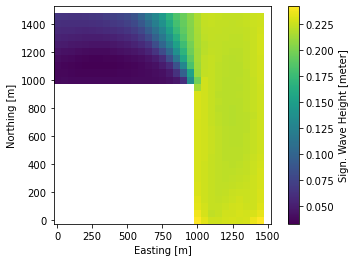

In [7]:
dsi["Sign. Wave Height"].plot()

In [8]:
dsi["Sign. Wave Height"].shape

(24, 31, 31)

(0.0, 0.2)

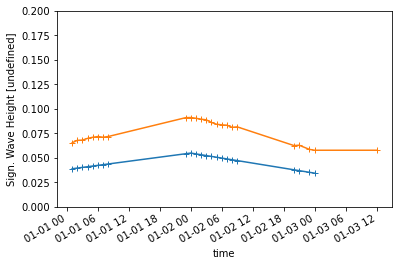

In [9]:
ax = dsi["Sign. Wave Height"].sel(x=250, y=1200).plot(marker='+')
ts["Sign. Wave Height"].plot(ax=ax,marker='+')
plt.ylim(0,0.2)

## Mean absolute error
Use `np.nanmean` to skip NaN.

In [10]:
mae = np.nanmean(np.abs(ts["Sign. Wave Height"].to_numpy() - dsi["Sign. Wave Height"][:,-2,0].to_numpy()))
mae

0.0008009996575613816

# Clean up

In [11]:
import os
os.remove("waves_3h.dfs2")